## Chapter: Practical 

- Topic-1 Introduction to keras_retinanet 
- Topic-2 Inference on an image.
- Topic-3 Evaluating on coco dataset 
- Topic-4 Undestanding mAP 
- Topic-5 Transfer learning using keras_retinanet 

## Topic-1 Introductions
So far we have seen how retinanet works by looking deep inside the network. We have decoupled each stage like network building, anchors generation, encoding ground truth, calculating loss functions etc. In this section we will look at ways to train, test and validate the network so that we are confident enough to solve any object detection problems. With increased spread of Deep learning across various industries, there are several people working in deep learning and a flood of research papers and code is being published every day claiming interesting gains in accuracies. Whenever you come across a paper which solves a complex problem, The first thing we need to do is to search for code which can replicate the results. There are papers and codes published by many people who claim to solve the problem but in reality they don't work. Though there are ways to know the credibility of the code by knowing the researcher and github stars it recieve but these are not robust ways to test someone code. 

1) If you are reading any code , the following sanity checks are must.
    - Check relavent repo (Here I found [keras_retinanet](https://github.com/fizyr/keras-retinanet) which have good number of github stars)
    - Check the github issues and see what kind of problems users facing using this code. (looking at the [issues](https://github.com/fizyr/keras-retinanet/issues) makes me feel that the code actually works and every question is being answered by someone or the other).
2) If you are okay with both of the above things then move on to the next few sanity checks (Here I am focussed on object detection)
    - Check if pretrained weights are released or not. If not search for other repos where you can find pretrained weights. Training these networks from scratch is the last thing you would like to do. If pretrained weights are available download them. In keras-retinanet downloaded weights are available [here](https://github.com/fizyr/keras-retinanet/releases/download/0.5.0/resnet50_coco_best_v2.1.0.h5)
    - Test the model on few images and see how the model is working **[Inference section]**
    - Evaluate the model on val set and see if the claimed accuraices are being achieved or not. In the readme.md files the authors claims the following results.
    ```
    Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.350
     Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.537
     Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.374
     Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.191
     Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.383
     Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.472
     Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.306
     Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.491
     Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.533
     Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.345
     Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.577
     Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.681
    ```
 
We wil understand in sometime what each and every attribute on the above lines represents. For now keep in mind that object detection used mAP (mean average precision as the metric)
 - Using pretrained weights load the model and train it for few iterations and check weather the loss is saturated and low. 
 - Train the model from scratch for few iterations to check if the loss is converging or not (If you have enough compute power we can train for the entire time period. Usually this is not neccessary)
 - Test on a smaller dataset using transfer learning techniques and see the performance.

The above 5 discussed points 
- Inference
- Evaluate 
- Train using pretrained weights 
- Train not using pretrained weights
- Train and test the model on small new dataset using transfer learning.

If a code passes these 5 tests then we can claim that then we have a tool to solve object detection problem. Now in this module lets look into some of these sections.  I will not discuss train using pretrained weights and train without using pretrained weights as it is computational expensive. In general also, we need not strictly test these two steps. Some people usually train it for few interations and check if the loss is converging or not. We will also discuss what mAP means and how it is calculated. 

## Topic-2 Inference on an Image

In this section we will see how to run a pre-trained coco model on an image and get predictions. The following are the steps to solve this 
- Load necessary libraries 
- initalize the model and load the pretrained weights 
- read the image, preprocess it and predict on image
- visualize the output

## 2.1 Load the necessary libraries 

In [1]:
# import keras
import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

# set tf backend to allow memory to grow, instead of claiming everything
import tensorflow as tf

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)

# use this environment flag to change which GPU to use
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# set the modified tf session as backend in keras
keras.backend.tensorflow_backend.set_session(get_session())

Using TensorFlow backend.


## 2.2 initalize the model and load the pretrained weights 

In [2]:
from keras_retinanet import models
model_path = "../../weight_files_imp/resnet50_coco_best_v2.1.0.h5"
model = models.load_model(model_path, backbone_name="resnet50")

Instructions for updating:
Colocations handled automatically by placer.


/mnt/nfshome1/FRACTAL/vanapalli.prakash/miniconda3/envs/keras/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


## 2.3 Read image, preprocess it and then predict on it.

In [3]:
# load image
image = read_image_bgr('../000000122851.jpg')

# copy to draw on
draw = image.copy()
draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

# preprocess image for network
image = preprocess_image(image)
image, scale = resize_image(image)

# process image
start = time.time()
boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
print("processing time: ", time.time() - start)

processing time:  8.133852005004883


## 2.4 Visualize the output

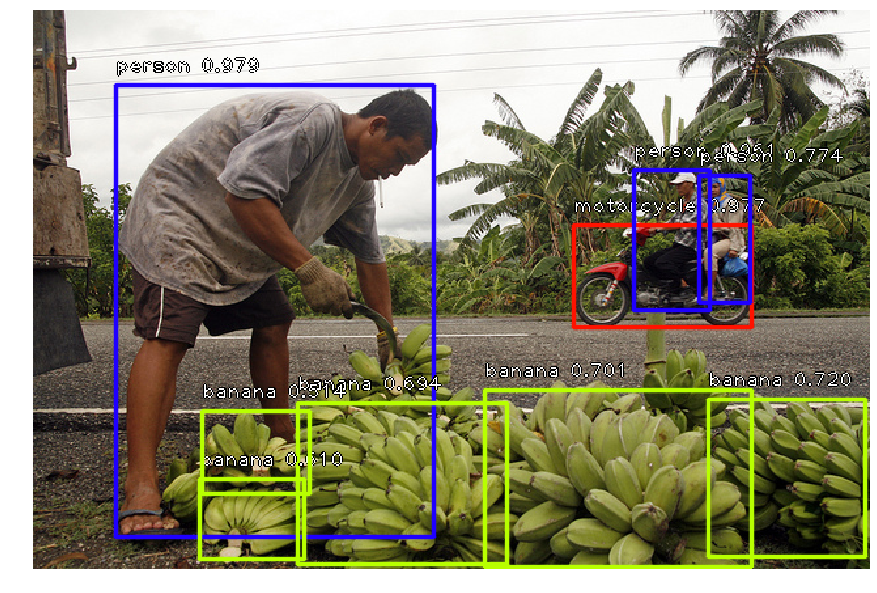

In [4]:
# correct for image scale

labels_to_names = {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell phone', 68: 'microwave', 69: 'oven', 70: 'toaster', 71: 'sink', 72: 'refrigerator', 73: 'book', 74: 'clock', 75: 'vase', 76: 'scissors', 77: 'teddy bear', 78: 'hair drier', 79: 'toothbrush'}

boxes /= scale

# visualize detections
for box, score, label in zip(boxes[0], scores[0], labels[0]):
    # scores are sorted so we can break
    if score < 0.5:
        break
        
    color = label_color(label)
    
    b = box.astype(int)
    draw_box(draw, b, color=color)
    
    caption = "{} {:.3f}".format(labels_to_names[label], score)
    draw_caption(draw, b, caption)
    
plt.figure(figsize=(15, 15))
plt.axis('off')
plt.imshow(draw)
plt.show()

## Topic-3 Evaluating the model.

Using keras_retinanet evaluation of the object detection pipeline is only a two step process. We need to call the respective data generator and evaluate coco. There are several data generators in keras_retinanet
- CocoGenerator
- CSVGenerator
- PascalVocGenerator
- KittiGenerator
- OpenImagesGenerator

Since we have Pretrained weights for coco model. We will use CocoGenertor in this section. 

For evaluating on the coco dataset, keras_retinanet has a function called evaluate_coco, which internally uses pycocotools cocoeval functions. Lets code and see ourselves. 


## 3.1 load the libraries 

In [6]:
from keras_retinanet.utils.coco_eval import evaluate_coco
from keras_retinanet.preprocessing.coco import CocoGenerator

## 3.2 Load the Generator

In [7]:
image_min_side = 800
image_max_side = 1333
path_to_data = "/public_datasets/coco/"

validation_generator = CocoGenerator(
            path_to_data,
            'val2017',
            image_min_side=image_min_side,
            image_max_side=image_max_side)

loading annotations into memory...
Done (t=1.15s)
creating index...
index created!


## 3.3 Evaluate on the dataset.
This will create two json files called val2017_bbox_results.json and val2017_processed_image_ids.json. The val2017_bbox_results.json contains all the predictions in the similar format to how annotations are stored in the coco files. This file is internally used by the cocoeval function to calculate the mAP.

In [8]:
evaluate_coco(validation_generator, model, 0.05)

COCO evaluation: 100% (5000 of 5000) |###| Elapsed Time: 0:12:37 Time:  0:12:37


Loading and preparing results...
DONE (t=5.28s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=78.07s).
Accumulating evaluation results...
DONE (t=14.17s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.350
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.537
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.374
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.191
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.383
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.472
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.306
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.491
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.533
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=

array([0.35028274, 0.53688466, 0.37352611, 0.19106903, 0.38346983,
       0.471828  , 0.3059933 , 0.49110692, 0.53284733, 0.34485422,
       0.57699452, 0.68136929])

## Topic-4 Understanding mAP 

In object detection there are two different mAP's usually followed in the research community, **vocmAP** and **CocomAP**. Before the introduction of COCO dataset, researchers used to participate in Pascal VOC challege and then the evaluation metric of average precision which today is termed as **vocmAP**.  The [Pascal VOC challenge](http://host.robots.ox.ac.uk/pascal/VOC/), official documentation explaination on their criteria for object detection metrics can be accessed [here](http://host.robots.ox.ac.uk/pascal/VOC/voc2012/htmldoc/devkit_doc.html#SECTION00050000000000000000). The current metrics used by the current PASCAL VOC object detection challenge are the Precision x Recall curve and Average Precision, which we will be discussing ahead. With introduction of [COCO Detection challege](https://competitions.codalab.org/competitions/5181), the researchers proposed different metrics to evaluate the accuracy of object detection of different algorithms. [here](http://cocodataset.org/#detection-eval) you can find a documentation explaining the 12 metrics used for characterizing the performance of an object detector on COCO. These metrics will be discussed in the coming sections. The latest large scale [Google Open Images Dataset V5 Competition](https://storage.googleapis.com/openimages/web/challenge.html) also uses mean Average Precision (mAP) over the 500 classes to evaluate the object detection task.

### Important definitions
1) **Intersection Over Union (IOU)** is the measure based on Jaccard Index that evaluates the overlap between two bounding boxes. It requires a ground truth bounding box and a predicted bounding box. By applying the IOU we can tell if a detection is valid (True Positive) or not (False Positive).
IOU is given by the overlapping area between the predicted bounding box and the ground truth bounding box divided by the area of union between them

![iou](../images/iou.png)  

<center><img src='../images/iou.gif'></center>

2) **True Positive(TP)** : A correct detection. Detection with IOU ≥ threshold.  
3) **False Positive (FP)**: A wrong detection. Detection with IOU < threshold.  
4) **False Negative(FN)**: A ground truth not detected.  
5) **True Negative(TN)** : It would represent a corrected misdetection. In the object detection task there are many possible bounding boxes that should not be detected within an image. Thus, TN would be all possible bounding boxes that were corrrectly not detected (so many possible boxes within an image). That’s why it is not used by the metrics.  

<center><img src='../images/confusion_matrix.png'></center>

6) **Precision**: percentage of positive predictions.  
<center><img src='../images/precision.gif'></center>

7) **Recall**: percentage of true positive detected among all relevant ground truths.  
<center><img src='../images/recall.gif'></center>

8) **Precision x Recall curve:** The Precision x Recall curve is a good way to evaluate the performance of an object detector as the confidence is changed. There is a curve for each object class. An object detector of a particular class is considered good if its prediction stays high as recall increases, which means that if you vary the confidence threshold, the precision and recall will still be high. This statement can be more intuitively understood by looking at the above equations of P and R and keeping in mind that TP+FN = all ground truth = constant, so Recall increases, means TP increased, hence FN will decrease. As TP has increased, only if FP decreases, will the Precision remain high i.e. the model will be doing less mistakes and hence will be good. Usually, Precision x Recall curve start with high precision values, decreasing as recall increases. You can see an example of the Precision x Recall curve in the next point (Average Precision).  

9) **Average Precision(AP):** It is calculated using area under the curve (AUC) of the Precision x Recall curve. As AP curves are often zigzag curves (shown later), comparing different curves (different detectors) in the same plot usually is not an easy task. In practice AP is the precision averaged across all recall values between 0 and 1. 

10) **Mean Average Precision(mAP):** The mAP score is calculated by taking the mean AP over all classes and/or over all IoU thresholds, depending on weather it is VOC AP or COCO mAP .


## 4.1 VOC AP and mAP
PASCAL VOC 2012 challenge uses the interpolated average precision. It tries to summarize the shape of the Precision x Recall curve by averaging the precision at a set of eleven equally spaced recall levels [0, 0.1, 0.2, … , 1]

<center><img src='../images/voc_ap.gif'></center>

with 

<center><img src='../images/voc_ap_map.gif'></center>

Instead of using the precision observed at each point, the AP is obtained by interpolating the precision at each level r taking the maximum precision whose recall value is greater than r. Lets take an illustrative example to understand this. The below diagram contains 7 images with 15 ground truth objects(green boxes)and 24 detected objects(red boxes). The table below that shows various calculations for each detected box. 

![mAP illustrative example](../images/mAP_illustrative.png)

![mAP table](../images/mAP_table.png)

Please observe the above table. The last column identifies the detections as TP or FP. In this example a TP is considered if IOU≥30%, otherwise it is a FP. Note that, in some images there are more than one detection overlapping a ground truth that are TP (Images 2, 3, 4, 5, 6 and 7). For those cases the detection with the highest IOU is taken, discarding the other detections, as described in PASCAL VOC paper. A prediction is positive if IoU > 0.5. If there are 5 detections of a single object , only 1 with the highest IoU is counted correct detection(TP) and rest 4 are false detections(FP). The P-R curve is plotted by calculating the precision and recall values of the accumulated TP or FP detections. For this, first we need to order the detections by their confidences, then we calculate the precision and recall for each accumulated detection as shown in the table above.

Note: Total gt boxes = 15. So, recall will always be calculated as (Acc TP)/15 in this case. 

For obtaining the interpolated average precision, the interpolated precision values are obtained by taking the maximum precision whose recall value is greater than its current recall value. The follwing curve is obtained

![precision recall](../images/precision_recall.png)

For getting the AP for a given class, we just need to calculate the AUC(Area Under Curve) of the interpolated precision. For PASCAL VOC challenge, only 1 IoU threshold of 0.5 is considered. So the mAP is the average of AP of all 20 object classes.

## 4.2 COCOmAP 
For the COCO 2017 challenge, the mAP was calculated by averaging the AP over all 80 object categories AND all 10 IoU thresholds from 0.5 to 0.95 with a step size of 0.05. The authors hypothesize that averaging over IoUs rewards detectors with better localization.

To make it more clear, first the AP is calculated for IoU threshold of 0.5 for each class i.e. We calculate the precision at every recall value(0 to 1 with a step size of 0.01), then it is repeated for IoU thresholds of 0.55,0.60,…,.95 and finally average is taken over all the 80 classes and all the 10 thresholds to get the primary metric used in the challenge.

Some more metrics have been defined in the challenge, like AP across scales for evaluating detections based on the object size inside the image and seeing whether the model is doing good for just large objects or just small objects or is it doing good for objects of varying sizes. The authors have defined small objects with those having area(h x w) less than 32² (on pixel scale), medium objects as those having area between 32² and 96² and large objects with area(h*w) greater than 96².

![Coco mAP](../images/cocomap.png)


NOTE : All the metrics are computed allowing for at most 100 top-scoring detections per image (across all categories). More details can be found [here](http://cocodataset.org/#detection-eval)

## Topic-5 Transfer learning using RetinaNet
As we have seen transfer learning in image classification and image segmentation, In object detection too transfer learning is an important concept. It is very difficult to gather large scale datasets for every problem statement you define, so pre-trained networks helps in this context. Most of the researchers who release papers, generally release code and pre-trained weights. Using the above framework we discussed, we can test the code base to some extent and use it in our tool box if everything is working fine. 

In object detection primarily, we will find pre-trained weights of VOC dataset, COCO dataset and OpenImages dataset. with the order of increase in the size of the dataset and classes, it is better to have openimages pretrained weights, then coco dataset pretrained weights then VOC dataset pretrained weights. Most of the researchers don't release the pretrained weights of openimages as it is too costly to train and test. So you will find coco dataset pretrained weights. Also for object detection since they have classification backends, All the networks backend are first initalized with imagenet pretrained weights and then trained on coco dataset. So even though coco dataset has only ~0.118 million images, it is still trained on a very large scale dataset. 

Also before you are looking to detect any particular object, we need to do the following sanity checks
1) Weather the object (say cow) is present in COCO dataset, VOC dataset and Openimages or any other dataset. If it is present, it is best mix your collected data with the already available data.
2) How different is the object in your dataset and other dataset? The difference can be interms of size of the objects, volumes of the objects inside the image and the background?
 - Size of the object: Sometimes the data you have in hand might have non-focussed cow images which are grazing in fields but the pretrained weights data file might have only cows focused images.
 - volumes of the objects: Sometimes the data you have in hand might have 100s of cows in a single image but the pretrained weights data file might have mostly ~2-3 cows in the data. 
 - background and location: The data captured by the pretrained weights might only contain images captured in Australia, Newzland and USA but the dataset at your hand might contain Indian cows. The data you captured might be in a dairy farm, where as the data in COCO might be of cows grazing in fields.
 
 All these baises will harm your accuracies. So it is good to take of these things. 
 
 
 In general I follow the below steps while working with any image problems.
 1) Collect small scale dataset to solve the problem.
 2) See if any pretrained weights have the same classes. If yes, using pretrained weights of those dataset, check the mAP on your dataset. This will be your best benchmark.
 3) If the accuracy is low, find out what bias it has and collect more data in that aspect. Use the pretrained weights to train the network further. 
 4) If you don't have the required object in any other classes, find a relavant dataset which is close to your dataset, find pretrained weights of it. Gather datasets and train it incrementally with time.

Now lets see how we can achieve transfer learning to train a network which can accurately identify human heads in the crowd. This is an important problem to solve as this is a core integral part of survillence. For an algorithm to identify people inside an image, it involves two steps 
- In a image, find the location of all the human faces.
- Compare the faces with the existing database of signatures. 

The details of the dataset we are using in this course are described in this paper and i request the readers to go through this paper for proper understanding of the dataset. [link](https://arxiv.org/pdf/1805.00123.pdf). The original dataset is hosted on this [website](http://www.crowdhuman.org/)

The CrowdHuman dataset is large, rich-annotated and contains high diversity images for detecting humans in the images.  There are a total of470K human instances from the train and validation subsets, and 22.6persons per image, with various kinds of occlusions in the dataset, Compared to other datasets, the statistical number of persons per image is only 0.32 in Caltech-USA,4.01 in COCOPersons, and 6.47 in CityPersons datasets. Since the number of humans is very high, the dataset is little different from coco dataset. 

The dataset is annotated with 
- visible human bounding box
- human head bouding box 
- full human bounding box 

![crowd human](../images/crowdhuman.png)

To make things simple for us, I am subsetting the dataset on two basis
- limit the number of images to train by 4000 and validation by 1000 images. 
- limit the number of classes to only head classes. 

This allow us to quickly train the dataset and see how transfer learning works.

## 5.1 Load the dataset 

The original data is given in .odgt format, I have converted those files into csv. Instead of using all the files, I have taken only 5000 images from the datasets, split the dataset train (4000 images) and val (1000 images) randomly. The below code loads both train and val file. 

```python
import pandas as pd 
train = pd.read_csv("../train.csv")
val = pd.read_csv("../val.csv")
print(train.shape, val.shape)
print(train.head(5))
```

set up the environment and start the session

```python
import os 
import tensorflow as tf 
import keras

os.environ['CUDA_VISIBLE_DEVICES'] = "0"

def get_session():
    """ Construct a modified tf session.
    """
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)

keras.backend.tensorflow_backend.set_session(get_session())
```

## 5.2 Load the datagenerators
since our dataset is in csv format, we can use csvdatagenerator. It takes the following parameters

|param| value|
|---|----|
|batch_size| 2|
|backbone| resnet50|
|image_min_side| 800|
|image_max_side| 1333|

```python
from keras_retinanet import models
backbone = models.backbone("resnet50")

batch_size = 2 
image_min_side = 800
image_max_side = 1333 
preprocess_image = backbone.preprocess_image
```
The preprocess_image is the preprocessing function used while training resnet50 for image classification on imagenet.

There is a config file which have the following params defined. It is stored as an .ini file. For people who want to know more about .ini file follow this [link](https://docs.python.org/3/library/configparser.html) 

|param| value|
|---|----|
| ratios| 0.5, 1., 2.|
| scales | 1., 1.2599211, 1.587401|
| sizes | 32, 64, 128, 256, 512 |
| strides | 8, 16, 32, 64, 128 |

```python
from keras_retinanet.utils.config import read_config_file
config = read_config_file("../config.ini")
config
print(config["anchor_parameters"]["ratios"].split(" "))
# ['0.5', '1.', '2.']
```

For data augumentation, call the data generator 

``` python
from keras_retinanet.utils.transform import random_transform_generator

transform_generator = random_transform_generator(
            min_rotation=-0.1,
            max_rotation=0.1,
            min_translation=(-0.1, -0.1),
            max_translation=(0.1, 0.1),
            min_shear=-0.1,
            max_shear=0.1,
            min_scaling=(0.9, 0.9),
            max_scaling=(1.1, 1.1),
            flip_x_chance=0.5,
            flip_y_chance=0.5,
)
```

Specify the location of train_file, val_file and class_id file and load both train generator and val generator 

```python
from keras_retinanet.preprocessing.csv_generator import CSVGenerator
train_ann_loc = "../train.csv"
classes_loc = "class_id.csv"
val_ann_loc = "../val.csv"
train_generator = CSVGenerator(train_ann_loc,
                               classes_loc,
                               base_dir = "../../data/train_01/",
                               transform_generator=transform_generator,
                               batch_size = batch_size, 
                               image_min_side = image_min_side, 
                               image_max_side = image_max_side, 
                               preprocess_image = preprocess_image,
                               config = config)

validation_generator = CSVGenerator(val_ann_loc,
                                    classes_loc,
                                    base_dir = "../../data/train_01/",
                                    batch_size = batch_size,
                                    image_min_side = image_min_side, 
                                    image_max_side = image_max_side, 
                                    preprocess_image = preprocess_image,
                                    config = config)

```

## 5.3 Load the prediction model and training model

While training the model there are a two kinds of training
- training the network on new dataset
- finetuning on the same dataset. this happens when u want to train for some more epochs. we will call this snapshot training 

to do snapshot training, we need to have access to weights. the training model and prediction model can be loaded in the following way.

```python
from keras_retinanet.utils.config import parse_anchor_parameters
from keras_retinanet.models.retinanet import retinanet_bbox

anchor_params = parse_anchor_parameters(config)
model_path = "../../weight_files_imp/resnet50_coco_best_v2.1.0.h5"
model = models.load_model(model_path, backbone_name="resnet50")
training_model = model
prediction_model = retinanet_bbox(model=model, anchor_params=anchor_params)
```

Incase if the model is training on a new dataset. The bin/train.py file inside keras_retinanet has a function called **create_models**. Te following params are defined in it. 

| params | definition |
|----|----|
| backbone_retinanet | which backbone to use to build the model|
| num_classes | number of classes in the dataset|
| weights | pretrianed weights to use |
| multi_gpu | wheather to use multigpu or not|
| freeze_backbone| wheather to freeze the resnet classification backbone network or not |
| lr | learning rate|
| config | scales, ratios, strides adn ratios to use|

```python
from keras_retinanet.bin.train import create_models

model, training_model, prediction_model = create_models(
    backbone_retinanet=backbone.retinanet,
    num_classes=train_generator.num_classes(),
    weights=model_path,
    multi_gpu=0,
    freeze_backbone=False,
    lr=1e-5,
    config=config)
```

## 5.4 Create Callbacks for Evaluation, Schedular, snapshots saving
A callback is a set of functions to be applied at given stages of the training procedure. You can use callbacks to get a view on internal states and statistics of the model during training. You can pass a list of callbacks (as the keyword argument callbacks) to the .fit() method of the Sequential or Model classes. The relevant methods of the callbacks will then be called at each stage of the training. 

Here we will be using 
- Evaluation callback to create a snapshot of evaluation method
- schedular callback to change learning rate while training.
- snapshots callback to save the model weights after every epoch

Evaluate callback
```python
from keras_retinanet.callbacks.eval import Evaluate
from keras_retinanet.callbacks import RedirectModel
evaluation = Evaluate(validation_generator, weighted_average=True)
evaluation = RedirectModel(evaluation, prediction_model)
```

snapshot callback
```python
snapshot_path = "model_weights/"
dataset_type = "csv"
checkpoint = keras.callbacks.ModelCheckpoint(
            os.path.join(
                snapshot_path,
                '{backbone}_{dataset_type}_{{epoch:02d}}.h5'.format(backbone=backbone, dataset_type="csv")
            ),
            verbose=1,
            # save_best_only=True,
            # monitor="mAP",
            # mode='max'
        )
checkpoint = RedirectModel(checkpoint, model)
```

scheular callback
```python
sched = keras.callbacks.ReduceLROnPlateau(
        monitor    = 'loss',
        factor     = 0.1,
        patience   = 2,
        verbose    = 1,
        mode       = 'auto',
        min_delta  = 0.0001,
        cooldown   = 0,
        min_lr     = 0
)
```

list of all the call backs 
```python
callbacks = [evaluation, checkpoint, sched]
```

## 5.5 training for several epochs.

We can call fit_generator function on training_model. The steps_per_epoch is given 2000 here because I have 4k images in my dataset and my batch_size is 2, which leaves me with 4k/2 = 2000. I am training here for 10 epochs. 

```python
## 5.5 Training 
training_model.fit_generator(
        generator=train_generator,
        steps_per_epoch=2000,
        epochs=10,
        verbose=1,
        callbacks=callbacks,
        workers=8,
        use_multiprocessing=True,
        max_queue_size=10,
        validation_data=validation_generator)
```

## 5.6 End notes
This is it. Now we have learnt how to train on other datasets using keras_retinanet package. Thanks for taking this course. Hope you have understood how object detection. We will keep updating the forms with new research papers and their summary notes along with github links. 

Some external links to follow latest research 
- https://paperswithcode.com/task/object-detection